## Summary:

***Objective:*** Predict rent prices across Canada using various regression techniques.

***Initial Approach:*** 
- Applied polynomial regression to model non-linear relationships between features and rent prices,
- Established a baseline for performance evaluation.

***Interaction Terms:*** 
- Used LassoCV for feature selection and regularization.
- Encountered increased RMSE and high Variance Inflation Factor (VIF) values due to multicollinearity.

***Feature Selection:*** 
- Removed features with high VIF to address multicollinearity.
- Improved R-squared value but increased RMSE.

***Final Model:*** 
- Employed RidgeCV regression to stabilize coefficients and manage multicollinearity.
- Evaluated the model using K-fold cross-validation to ensure robustness and generalizability.
- Achieved better model performance and improved prediction accuracy.

***Outcome:*** Demonstrated the iterative process of model refinement and the impact of different regression techniques on predictive accuracy, validated through K-fold cross-validation.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Load data

In [3]:
df = pd.read_csv('D:\\concordia-bootcamps\\M5-P6-Regression_Project-main\\canada_rent.csv')

In [4]:
print(df.columns)

Index(['rentfaster_id', 'city', 'province', 'address', 'latitude', 'longitude',
       'lease_term', 'type', 'price', 'beds', 'baths', 'sq_feet', 'link',
       'furnishing', 'availability_date', 'smoking', 'cats', 'dogs'],
      dtype='object')


### 1. Exploratory data analysis (EDA)

In [6]:
# drop the unrealted columns
df = df.drop(columns=['rentfaster_id', 'link', 'availability_date', 'address'], axis=1)

In [7]:
# Check the length of price == 0 and price == 1
print(len(df[(df['price'] == 0) | (df['price'] == 1)]))

233


In [8]:
# Drop the rows since price is our target value
df.drop(df[df['price'].isin([0,1])].index, inplace=True)

In [15]:
# check the sum of null values 
df.isnull().sum()

city             0
province         0
latitude         0
longitude        0
lease_term      19
type             0
price            0
beds           128
baths          130
sq_feet       4048
furnishing       0
smoking       2692
cats           168
dogs           168
dtype: int64

In [17]:
# Handling Missing values

# Convert str to numeric, coercing errors to NaN
df['sq_feet'] = pd.to_numeric(df['sq_feet'], errors='coerce')

# Convert 0 values to NaN
df['sq_feet'].replace(0, np.nan, inplace=True)

# Fill NaN values with the mean of the total dataset
mean_square_feet = df['sq_feet'].mean()
df['sq_feet'].fillna(mean_square_feet, inplace=True)

# Verify that there are no NaN values, or 0 values left 
print('Number of NaN values after filling:', df['sq_feet'].isna().sum())
print('Number of 0 values after filling:', len(df[df['sq_feet'] == 0]))



Number of NaN values after filling: 0
Number of 0 values after filling: 0


C:\Users\Zixian Ye\AppData\Local\Temp\ipykernel_35048\4251464854.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['sq_feet'].replace(0, np.nan, inplace=True)
C:\Users\Zixian Ye\AppData\Local\Temp\ipykernel_35048\4251464854.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.



In [19]:
# drop the null values rows in beds, baths, and lease_term
df.dropna(subset=['beds', 'baths', 'lease_term'], inplace=True)

In [21]:
# Fill smoking, cats, and dogs Null values to the mode value
# Create a list of cols
cols_to_fill =['smoking', 'cats', 'dogs']

# Loop through each col
for col in cols_to_fill:
    mode_value = df[col].mode()[0]
    df[col].fillna(mode_value, inplace=True)

C:\Users\Zixian Ye\AppData\Local\Temp\ipykernel_35048\2446246485.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode_value, inplace=True)
C:\Users\Zixian Ye\AppData\Local\Temp\ipykernel_35048\2446246485.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col].fillna(mode_value, inplace=Tr

In [23]:
# Check the unique values in beds col
print(df['beds'].unique())

['2 Beds' '3 Beds' 'Studio' '1 Bed' '5 Beds' '4 Beds' '6 Beds' 'none Beds'
 '8 Beds' '7 Beds' '9 Beds']


In [25]:
# Replace 'Studio' and 'none Beds' with 0
df['beds'] = df['beds'].replace({'Studio':0, 'none Beds': 0})

In [27]:
# Convert other bed descriptions to str
df['beds'] = df['beds'].astype(str).str.extract(r'(\d+)')[0]

In [29]:
# Convert to numeric, coercing errors to NaN
df['beds'] = pd.to_numeric(df['beds'], errors='coerce')

In [31]:
# Check the unique values in baths col
print(df['baths'].unique())

['2.5' '1' '2' '1.5' '3.5' '4' '3' '5' 'none' '4.5' '7.5' '5.5' '6' '6.5'
 '7' '8' '0']


In [33]:
# Replace none with 0
df['baths'] = df['baths'].replace('none', 0)
# Convert to numeric, coercing errors to NaN
df['baths'] = pd.to_numeric(df['baths'], errors='coerce')

In [35]:
# Check the sum of null values
df.isnull().sum()

city          0
province      0
latitude      0
longitude     0
lease_term    0
type          0
price         0
beds          0
baths         0
sq_feet       0
furnishing    0
smoking       0
cats          0
dogs          0
dtype: int64

### Data Visualization

C:\Users\Zixian Ye\AppData\Local\Temp\ipykernel_35048\467985898.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(x='beds', y='sq_feet', data=df, ax=ax1, color='blue', ci=95, marker='o')
C:\Users\Zixian Ye\AppData\Local\Temp\ipykernel_35048\467985898.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(x='beds', y='price', data=df, ax=ax2, color='red', ci=95, marker='o')


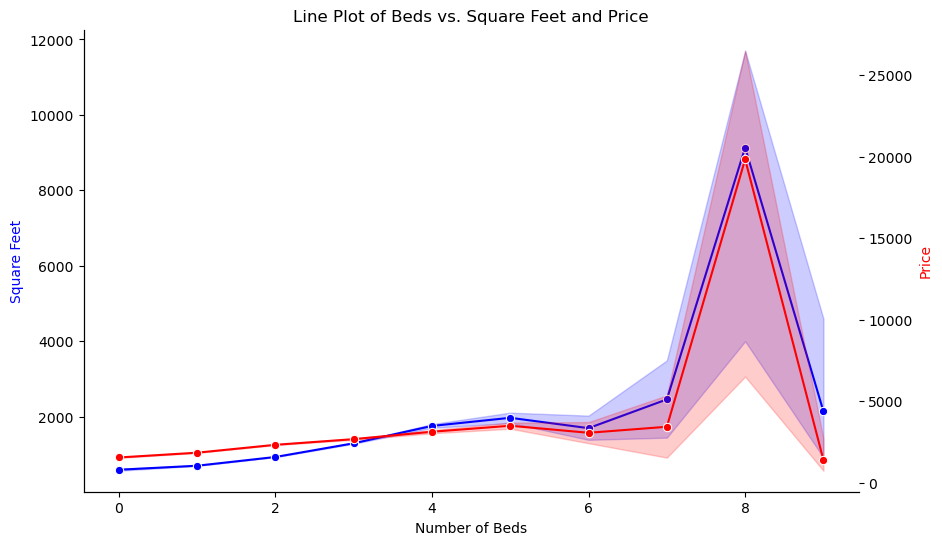

In [38]:
# Two plots represent the relationship of beds with sq_feet and beds with price
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot number of beds against square feet
sns.lineplot(x='beds', y='sq_feet', data=df, ax=ax1, color='blue', ci=95, marker='o')
ax1.set_xlabel('Number of Beds')
ax1.set_ylabel('Square Feet', color='blue')

# Plot number of beds against price
ax2 = ax1.twinx()
sns.lineplot(x='beds', y='price', data=df, ax=ax2, color='red', ci=95, marker='o')
ax2.set_ylabel('Price', color='red')

plt.title('Line Plot of Beds vs. Square Feet and Price')
sns.despine()
plt.show()

As the number of beds (x) increases, both square footage and price exhibit a similar upward trend, indicating a positive correlation between the number of beds and square footage. This correlation could potentially lead to multicollinearity in the regression model.

The shaded area in the plot represents the 95% confidence interval. At 8 beds, the ranges for both price and square footage are notably wider, which may distort the overall trend and affect the model's accuracy.

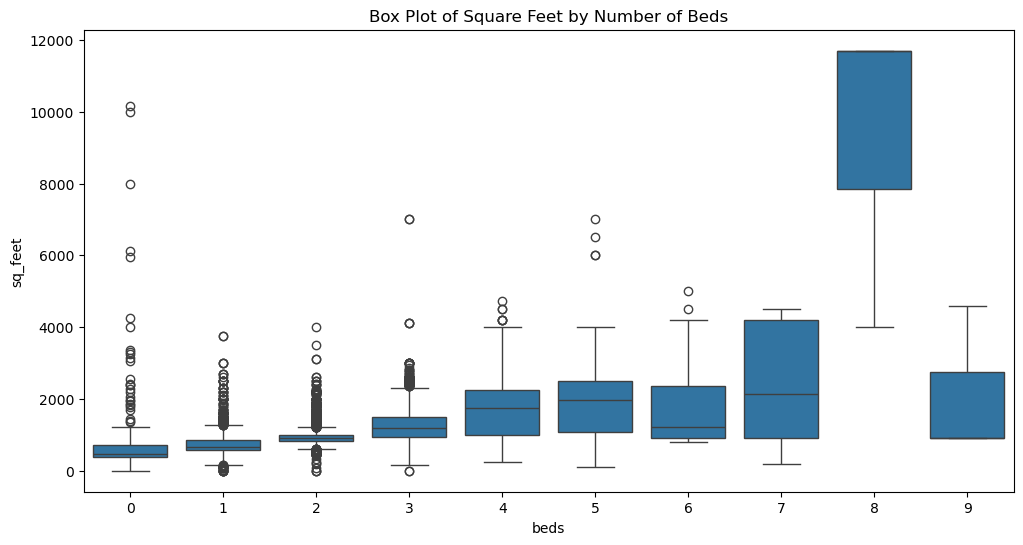

In [40]:
plt.figure(figsize=(12, 6))
#Create a box plot for 'sq_feet' against 'beds'
sns.boxplot(x='beds', y='sq_feet', data=df)
plt.title('Box Plot of Square Feet by Number of Beds')
plt.show()

From the boxplot, it is evident that there are numerous outliers in the data, particularly for properties with no bedrooms, which exhibit significant variability in size. This variability may be attributed to different property types, such as Main floor or Office, which do not follow the typical trend where more bedrooms generally correlate with increased square footage. To address this, incorporating other factors and interaction terms in the analysis could help mitigate the impact of these outliers and provide a more accurate model.

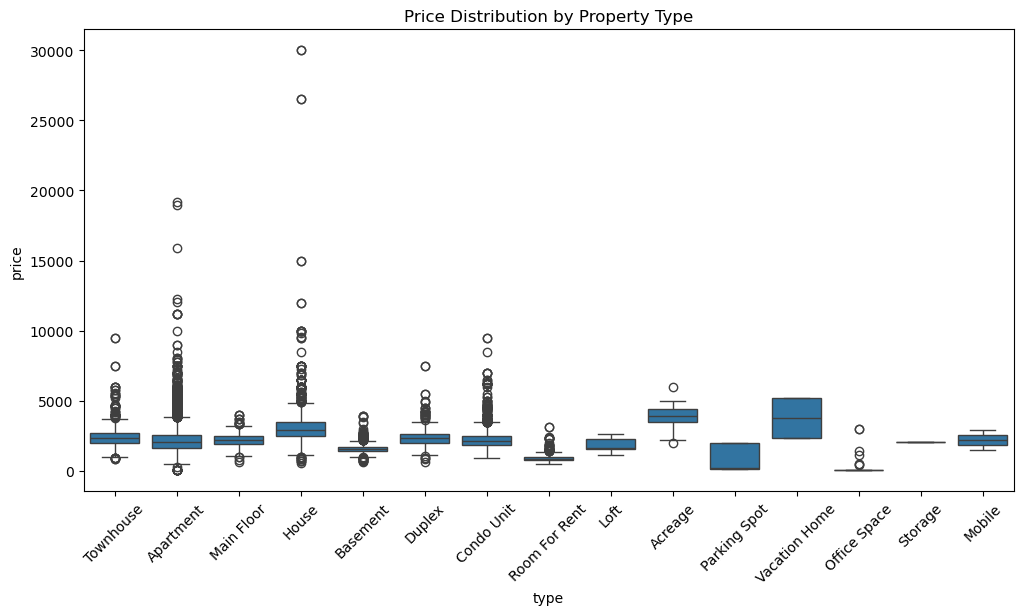

In [44]:
# Box plot for price by type of properties
plt.figure(figsize=(12, 6))
sns.boxplot(x='type', y='price', data=df)
plt.xticks(rotation=45)
plt.title('Price Distribution by Property Type')
plt.show()

From the boxplot, for residential properties (Townhouse, Apartment, Condo unit, Duplex, Loft), the middle 50% of prices range between CAD 2,000 and CAD 3,000. This range represents a typical price range for these types of properties. Notably, in the Apartment segment, the presence of outliers increases the variability of prices, which may be influenced by the lease_term, sq_feet, or other factors.

50% of the House rental prices are generally higher than those of residential properties. Vacation home rental prices range between CAD 4,000 and CAD 5,500, reflecting a premium for short-term stays, it may have positive correlation to lease_term in short time period. 

Room rentals and basement rentals typically have lower prices, around CAD 1,000, which may be due to shared kitchen and bathroom facilities. 

Parking spots and storage rentals have the lowest rent prices, reflecting their functionality and limited size.


### 2.Prepare Data

##### Transform all the categorical columns into numerical format

In [49]:
# import lib
from sklearn.preprocessing import OneHotEncoder

# create instance of OneHotEncoder
enc = OneHotEncoder(drop='if_binary', sparse_output=False)

# fit and transform the econder on the categorical columns
encoder_cols = enc.fit_transform(df[['furnishing', 'lease_term', 'smoking', 'cats', 'dogs']])

# create a new df with the encoded cols
df1 = pd.DataFrame(encoder_cols, 
                   columns = enc.get_feature_names_out(['furnishing', 'lease_term', 'smoking', 'cats', 'dogs']))

# Remove the original cols
df = df.drop(columns = ['furnishing', 'lease_term', 'smoking', 'cats', 'dogs']).reset_index(drop=True)

# Join the new df into the orignial df
df = df.join(df1)

##### Combine cats and dogs columns as pets_allowed

In [52]:
# Convert cols to int and fill nan with 0
df['cats_True'] = df['cats_True'].fillna(0).astype(int)
df['dogs_True'] = df['dogs_True'].fillna(0).astype(int)

# Combine cols
df['pets_allowed'] = df['cats_True'] | df['dogs_True']

# drop orignial cats and dogs cols
df = df.drop(columns=['cats_True', 'dogs_True'])


##### Check the information with beds == 8

In [55]:
# fliter the df with beds == 8
filtered_df = df[df['beds'] == 8]

# Get the infor with price, sq_feet, and beds
filtered_df[['price', 'sq_feet', 'beds']].describe()

,price,sq_feet,beds
count,3.000000,3.000000,3.0
mean,19833.333333,9133.333333,8.0
std,11547.005384,4445.597073,0.0
min,6500.000000,4000.000000,8.0
25%,16500.000000,7850.000000,8.0
50%,26500.000000,11700.000000,8.0
75%,26500.000000,11700.000000,8.0
max,26500.000000,11700.000000,8.0


Starting from the first plot, which represents the relationship of Beds vs. Square Feet and Price, and we noticed when the number of beds = 8, the price and sq_feet all have a big increase. According to the information above, when the number of beds = 8, we have the following stats:

- price std: 11547
- sq_feet std: 4445.59
- count of bed=8 : 3
  
In conclude, since there are only 3 counts of 8 beds, which explains why the standard deviation of price in beds=8 is relatively high, and also it's less reliable to interpret.

##### Create dummy variables for province column

In [59]:
# Province is one of the important feature to include as predicting our target y

# get the unique values 
df['province'].unique()

array(['Alberta', 'British Columbia', 'Manitoba', 'New Brunswick',
       'Newfoundland and Labrador', 'Nova Scotia',
       'Northwest Territories', 'Ontario', 'Quebec', 'Saskatchewan'],
      dtype=object)

In [61]:
# Create dummy variables manually for province column
df = df.assign(
    Alberta=np.where(df['province'] == 'Alberta', 1, 0),
    British_Columbia=np.where(df['province'] == 'British Columbia', 1, 0),
    Manitoba=np.where(df['province'] == 'Manitoba', 1, 0),
    New_Brunswick=np.where(df['province'] == 'New Brunswick', 1, 0),
    Newfoundland_and_Labrador=np.where(df['province'] == 'Newfoundland and Labrador', 1, 0),
    Nova_Scotia=np.where(df['province'] == 'Nova Scotia', 1, 0),
    Northwest_Territories=np.where(df['province'] == 'Northwest Territories', 1, 0),
    Ontario=np.where(df['province'] == 'Ontario', 1, 0),
    Quebec=np.where(df['province'] == 'Quebec', 1, 0),
    Saskatchewan=np.where(df['province'] == 'Saskatchewan', 1, 0))

In [63]:
# Check the correlation in numeric cols
df.corr(numeric_only=True)

,latitude,longitude,price,beds,baths,sq_feet,furnishing_Furnished,furnishing_Negotiable,furnishing_Unfurnished,"furnishing_Unfurnished, Negotiable",...,Alberta,British_Columbia,Manitoba,New_Brunswick,Newfoundland_and_Labrador,Nova_Scotia,Northwest_Territories,Ontario,Quebec,Saskatchewan
latitude,1.000000,-0.891557,-0.238242,0.197249,0.174394,1.671718e-01,0.140604,0.084252,-0.165584,0.008100,...,0.819950,0.031662,0.050029,-0.018205,-0.008169,-0.117857,1.054918e-01,-0.808505,-0.293365,0.124798
longitude,-0.891557,1.000000,0.126793,-0.209661,-0.199877,-1.711305e-01,-0.148134,-0.094538,0.176982,-0.010758,...,-0.810939,-0.269698,0.033898,0.042919,0.057973,0.204762,-2.192049e-02,0.705721,0.468418,-0.052884
price,-0.238242,0.126793,1.000000,0.419250,0.488382,4.093879e-01,0.029314,-0.001647,-0.026141,-0.004823,...,-0.119548,0.078739,-0.090438,-0.016002,-0.025438,0.026197,-8.895545e-03,0.206893,-0.024175,-0.150052
beds,0.197249,-0.209661,0.419250,1.000000,0.672355,6.262195e-01,0.015992,0.046437,-0.034587,0.006484,...,0.248719,-0.064135,-0.029465,-0.001924,-0.011276,-0.015817,4.278287e-03,-0.151060,-0.110777,-0.037447
baths,0.174394,-0.199877,0.488382,0.672355,1.000000,6.213536e-01,0.045563,0.050997,-0.063679,0.003876,...,0.238815,-0.036444,-0.029191,-0.008390,-0.013927,-0.010618,-1.369309e-02,-0.137336,-0.108246,-0.081556
sq_feet,0.167172,-0.171131,0.409388,0.626220,0.621354,1.000000e+00,0.067679,0.079692,-0.096170,0.004140,...,0.223663,-0.065139,-0.035894,0.001186,-0.010971,0.000493,2.567105e-07,-0.153543,-0.052543,-0.056594
furnishing_Furnished,0.140604,-0.148134,0.029314,0.015992,0.045563,6.767911e-02,1.000000,-0.039307,-0.906317,-0.004274,...,0.183130,-0.027135,-0.051781,-0.006623,-0.006623,-0.021705,-8.551159e-03,-0.124886,-0.042132,-0.043012
furnishing_Negotiable,0.084252,-0.094538,-0.001647,0.046437,0.050997,7.969209e-02,-0.039307,1.000000,-0.384087,-0.001811,...,0.113782,-0.023490,-0.024254,-0.002807,-0.002807,-0.012845,-3.623887e-03,-0.072741,-0.038176,-0.020316
furnishing_Unfurnished,-0.165584,0.176982,-0.026141,-0.034587,-0.063679,-9.616990e-02,-0.906317,-0.384087,1.000000,-0.041766,...,-0.217484,0.035065,0.058116,0.007307,0.007307,0.025500,9.435068e-03,0.146241,0.055145,0.048356
"furnishing_Unfurnished, Negotiable",0.008100,-0.010758,-0.004823,0.006484,0.003876,4.140467e-03,-0.004274,-0.001811,-0.041766,1.000000,...,0.013049,-0.003043,-0.002637,-0.000305,-0.000305,-0.001397,-3.940654e-04,-0.008219,-0.004388,-0.002411


In [65]:
df.describe()

,latitude,longitude,price,beds,baths,sq_feet,furnishing_Furnished,furnishing_Negotiable,furnishing_Unfurnished,"furnishing_Unfurnished, Negotiable",...,Alberta,British_Columbia,Manitoba,New_Brunswick,Newfoundland_and_Labrador,Nova_Scotia,Northwest_Territories,Ontario,Quebec,Saskatchewan
count,25389.000000,25389.000000,25389.000000,25389.000000,25389.000000,25389.000000,25389.000000,25389.000000,25389.000000,25389.000000,...,25389.000000,25389.000000,25389.000000,25389.000000,25389.000000,25389.000000,25389.000000,25389.000000,25389.000000,25389.000000
mean,48.923886,-100.409601,2178.512457,1.752373,1.419237,917.401567,0.084879,0.016385,0.898539,0.000197,...,0.536335,0.044901,0.034109,0.000473,0.000473,0.009807,0.000788,0.255386,0.089054,0.028674
std,3.600123,17.887689,950.131629,0.968875,0.654611,439.302789,0.278707,0.126954,0.301944,0.014032,...,0.498688,0.207092,0.181513,0.021736,0.021736,0.098547,0.028056,0.436087,0.284828,0.166891
min,40.741802,-128.661880,15.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,45.424480,-114.074763,1639.000000,1.000000,1.000000,662.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.915149,-113.514792,2050.000000,2.000000,1.000000,900.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,51.098083,-79.405458,2550.000000,2.000000,2.000000,975.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,62.459246,-52.695472,29990.000000,9.000000,8.000000,11700.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [67]:
# Separate X and y features

# Independent features X
X = df[['Alberta', 'British_Columbia', 
        'Manitoba', 'New_Brunswick',
        'Newfoundland_and_Labrador', 
        'Nova_Scotia',
        'Northwest_Territories', 
        'Ontario', 'Quebec', 
        'Saskatchewan',
        'latitude', 'longitude',
        'beds', 'baths', 'sq_feet', 
        'pets_allowed',
        'lease_term_Long Term', 'lease_term_Short Term', 'lease_term_months',
        'smoking_Smoking Allowed', 'smoking_Non-Smoking',
        'smoking_Smoke Free Building']]

# Target variable y
y = df['price']

**X feature selection based on correlation:**
- Price and Latitude coef is (-0.238), and Latitude has positive relationship with beds, baths, sq_feet. Price and Longitude coef is (0.127), since Longitude and Latitude are -0.89 correlated, Longitude has neg relationship with beds, baths, sq_feet. 
- Pets is positively related to price. 
- In lease_term, I chose 'lease_term_Long Term', 'lease_term_Short Term', and 'lease_term_months' as an conclusion to represent the lease_term feature, since long term neg related to Price, and short term/ monthly rent is positively related to the price.
- For Smoking part, no smoking and pirce coef is 0.018, smoking allowed and price coef is -0.05, Smoke Free Building and price coef is 0.012, which is a sign that smoking will neg affect the price.

### First Model - Polynomial Regression

In [71]:
# Creat polyfeatures

# Create instance of PolynomialFeatures
poly_converter = PolynomialFeatures(degree=2, include_bias=False)

# Fit and transform X features
poly_features = poly_converter.fit_transform(X)

In [73]:
# Train_test split 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.15, random_state=1)

In [75]:
# Scale data with StandardScaler method
scale = StandardScaler()

X_train_scale = scale.fit_transform(X_train)
X_test_scale = scale.transform(X_test)

# Create instance of model
model = LinearRegression()
model.fit(X_train_scale, y_train)

LinearRegression()

In [77]:
# Predict the y values
y_pred = model.predict(X_test_scale)

# Obtain the metrics
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(MSE)
R2_scores = r2_score(y_test, y_pred)

MAE, MSE, RMSE, R2_scores

(384.80336545670616, 363671.6447291119, 603.0519419827051, 0.5297972557499231)

In [79]:
# import lib
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

# Add a constant for intercept
X_with_constant = sm.add_constant(X)

# Calculate VIF for each feature
pd.Series(
    [vif(X.values, i) for i in range(X.shape[1])],
    index=X.columns
)


Alberta                        11387.839518
British_Columbia                1039.853007
Manitoba                         569.217309
New_Brunswick                      5.496877
Newfoundland_and_Labrador          4.705841
Nova_Scotia                       89.772832
Northwest_Territories             19.808960
Ontario                         2974.083987
Quebec                           974.511819
Saskatchewan                     549.038845
latitude                          15.400538
longitude                        311.896305
beds                               2.129239
baths                              2.108322
sq_feet                            1.915381
pets_allowed                       1.123480
lease_term_Long Term               1.308519
lease_term_Short Term              1.211426
lease_term_months                  1.002156
smoking_Smoking Allowed            2.829576
smoking_Non-Smoking                6.243243
smoking_Smoke Free Building        4.542515
dtype: float64

**Summary for model:**
- Mean Absolute Error (MAE): 384.80
- Mean Squared Error (MSE): 363,671.64
- Root Mean Squared Error (RMSE): 603.05
- R-squared: 0.53

With the RMSE of 603.05 suggests that, on average, the model's predictions are off by about 603.05 units, and only approximately 53% of the variance in target variable is explained by the model. From the high vif values in province, which indicates the province's feature is highly correlated with one or more other features in the model.

### Second Model - LassoCV

In the second model, I will include interaction terms between residential property types ('Townhouse', 'Apartment', 'Main Floor', 'House', 'Basement', 'Duplex', 'Condo Unit', 'Room For Rent', 'Loft') and square footage. This approach is useful for capturing how the value of a square foot may vary across different property types. 
The approach involves:

1. Creating dummy variables for property types.
2. Generating interaction terms by multiplying each dummy variable by square footage.
3. Including these interaction terms in the model.

In [84]:
# Get the type unqiue values
df['type'].unique()

array(['Townhouse', 'Apartment', 'Main Floor', 'House', 'Basement',
       'Duplex', 'Condo Unit', 'Room For Rent', 'Loft', 'Acreage',
       'Parking Spot', 'Vacation Home', 'Office Space', 'Storage',
       'Mobile'], dtype=object)

##### Create dummy variables for type of property

In [86]:
# Create dummy variables manually for type of property
df = df.assign(
    Townhouse=np.where(df['type'] == 'Townhouse', 1, 0),
    Apartment=np.where(df['type'] == 'Apartment', 1, 0),
    Main_Floor=np.where(df['type'] == 'Main Floor', 1, 0),
    House=np.where(df['type'] == 'House', 1, 0),
    Basement=np.where(df['type'] == 'Basement', 1, 0),
    Duplex=np.where(df['type'] == 'Duplex', 1, 0),
    Condo_Unit=np.where(df['type'] == 'Condo Unit', 1, 0),
    Room_For_Rent=np.where(df['type'] == 'Room For Rent', 1, 0),
    Loft=np.where(df['type'] == 'Loft', 1, 0),
    Acreage=np.where(df['type'] == 'Acreage', 1, 0),
    Parking_Spot=np.where(df['type'] == 'Parking Spot', 1, 0),
    Vacation_Home=np.where(df['type'] == 'Vacation Home', 1, 0),
    Office_Space=np.where(df['type'] == 'Office Space', 1, 0),
    Storage=np.where(df['type'] == 'Storage', 1, 0),
    Mobile=np.where(df['type'] == 'Mobile', 1, 0))


In [88]:
# Manually create interaction terms between 'sq_feet' and each residential property type
for feature in ['Townhouse', 'Apartment', 'Main_Floor', 
                'House', 'Basement','Duplex', 'Condo_Unit', 
                'Room_For_Rent', 'Loft']:
    
    df[f'{feature}_x_sq_feet'] = df[feature] * df['sq_feet']
    

In [90]:
X = df[['Alberta', 'British_Columbia', 
        'Manitoba', 'New_Brunswick',
        'Newfoundland_and_Labrador', 
        'Nova_Scotia',
        'Northwest_Territories', 
        'Ontario', 'Quebec', 
        'Saskatchewan',
        'latitude', 'longitude',
        'beds', 'baths', 'sq_feet', 
        'pets_allowed',
        'lease_term_Long Term', 'lease_term_Short Term', 'lease_term_months',
        'smoking_Smoking Allowed', 'smoking_Non-Smoking',
        'smoking_Smoke Free Building'] +
        [f'{feature}_x_sq_feet' for feature in ['Townhouse', 'Apartment', 'Main_Floor', 
                                                'House', 'Basement', 'Duplex', 'Condo_Unit', 
                                                'Room_For_Rent', 'Loft']]]
y = df['price']

In [92]:
from sklearn.linear_model import LassoCV

# Create instance of model
lassocv_model = LassoCV(eps=0.01, n_alphas=200, cv=10)

# Fit the model on scaled_X_train
lassocv_model.fit(X_train_scale, y_train)

LassoCV(cv=10, eps=0.01, n_alphas=200)

In [93]:
# Evaluate lassocv model

y_pred = lassocv_model.predict(X_test_scale)

# Obtain metrics

MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(MSE)
R2_scores = r2_score(y_test, y_pred)

MAE, MSE, RMSE, R2_scores

(398.70925518513377, 386140.90352792037, 621.4023684601792, 0.5007460297288937)

After adding interaction terms, the RMSE increases and the R-squared decreases compared to the first model, it may be due to multicollinearity between the features, or issues with model specification. As a first step, I will use statsmodels to check the variance inflation factor (VIF) for each interaction term to assess multicollinearity

In [95]:
# import lib
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

# Add a constant for intercept
X_with_constant = sm.add_constant(X)

# Calculate VIF for each feature
pd.Series(
    [vif(X.values, i) for i in range(X.shape[1])],
    index=X.columns
)


Alberta                        11438.487477
British_Columbia                1043.195663
Manitoba                         571.548814
New_Brunswick                      5.519989
Newfoundland_and_Labrador          4.732844
Nova_Scotia                       90.263521
Northwest_Territories             19.886851
Ontario                         2988.098385
Quebec                           979.425030
Saskatchewan                     551.243787
latitude                          15.676219
longitude                        312.026448
beds                               2.241522
baths                              2.371310
sq_feet                           16.788901
pets_allowed                       1.213438
lease_term_Long Term               1.414948
lease_term_Short Term              1.215508
lease_term_months                  1.013839
smoking_Smoking Allowed            2.835714
smoking_Non-Smoking                6.258305
smoking_Smoke Free Building        4.554066
Townhouse_x_sq_feet             

With adding the interaction terms, the VIF values for the provinces are quite varied, with Alberta having the highest VIF by a large margin. This suggests that the interaction terms are causing significant multicollinearity issues specifically in Alberta.

In [96]:
# Check if removing the high VIF will affect the metrics

# Remove variables with high VIF and refit the model
# 'Alberta' and 'Ontario' have high VIF
X_reduced = X.drop(columns=['Alberta', 'Ontario'])
X_reduced = sm.add_constant(X_reduced)  # Add constant term for intercept

# Fit the model
model = sm.OLS(y, X_reduced).fit()  

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     927.6
Date:                Wed, 24 Jul 2024   Prob (F-statistic):               0.00
Time:                        23:07:23   Log-Likelihood:            -2.0093e+05
No. Observations:               25389   AIC:                         4.019e+05
Df Residuals:                   25359   BIC:                         4.022e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [99]:
# Obtain the metrics
from statsmodels.tools.eval_measures import mse, rmse
# Calculate the predict y
y_pred = model.predict(X_reduced)
# Calculate rmse, mse
rmse = rmse(y, y_pred)
mse = mse(y, y_pred)

mse,rmse

(438051.761737932, 661.8547890118587)

After removing Ontario and Alberta show the coefficients and statistical significance of the interaction terms between property types and square footage, however, rmse increased as r2 increased, so it's not a good approach to remove the high vif. Use RidgeCV to perform the regularization.

### Third Model - RidgeCV

In [109]:
# Import model
from sklearn.linear_model import RidgeCV

# Create instance of model
ridgecv_model = RidgeCV((0.1, 1.0, 10.0), scoring='neg_mean_absolute_error')

# Fit the model on scaled_X_train
ridgecv_model.fit(X_train_scale, y_train)

RidgeCV(scoring='neg_mean_absolute_error')

In [111]:
# Evaluate ridgecv model

y_pred = ridgecv_model.predict(X_test_scale)

from sklearn.metrics import mean_absolute_error,mean_squared_error

# Obtain metrics
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(MSE)
R2_scores = r2_score(y_test, y_pred)

MAE, MSE, RMSE, R2_scores

(394.7595003296128, 370047.7371827742, 608.3154914867565, 0.5215534011278853)

In [113]:
ridgecv_model.alpha_

0.1

### Perform K-Fold Cross-Validation

In [116]:
# Standard train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)

# Scale data
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [118]:
# import ridge
from sklearn.linear_model import Ridge
model = Ridge(alpha=0.1)

# Import cross_val_score
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, scaled_X_train, y_train, scoring='neg_mean_squared_error',cv=5)

abs(scores.mean())

459877.1057145479

### Final Evaluation

In [121]:
model.fit(scaled_X_train, y_train)

Ridge(alpha=0.1)

In [123]:
final_y = model.predict(scaled_X_test)

# Obtain metrics
MAE = mean_absolute_error(y_test, final_y)
MSE = mean_squared_error(y_test, final_y)
RMSE = np.sqrt(MSE)

MAE, MSE, RMSE

(380.56571820784825, 328480.3526058275, 573.1320551197844)

# The END